# Modèles de formation avec MLflow

Dans ce chapitre, vous apprendrez à créer des tâches de formation prêtes pour la production avec MLflow. Dans le cadre plus large des choses, nous nous concentrerons sur la façon de passer des tâches de formation dans l'environnement de bloc-notes que nous avons examinées dans les premiers chapitres à un format et un plan standardisés pour créer des tâches de formation. 

Plus précisément, nous examinerons les sections suivantes de ce chapitre :

* Créer votre projet de formation avec MLow• Mettre en œuvre la tâche de formation

* Évaluation du modèle
* Déploiement du modèle dans le registre de modèles

* Création d'une image Docker pour votre tâche de formation

Il est temps d'ajouter à la machine pyStock l'infrastructure de formation de la plate-forme d'apprentissage (ML) pour utiliser des modèles de validation de principe créés dans l'atelier développé au chapitre 3, Votre atelier de science des données dans un environnement de production. Dans ce chapitre, vous développerez un projet de formation qui s'exécute périodiquement ou lorsqu'il est déclenché par une arrivée de jeu de données. Le résultat principal du projet de formation est un nouveau modèle qui est généré en tant que résultat et enregistré dans le registre des modèles avec différents détails

Voici un aperçu du déroulement de la formation :

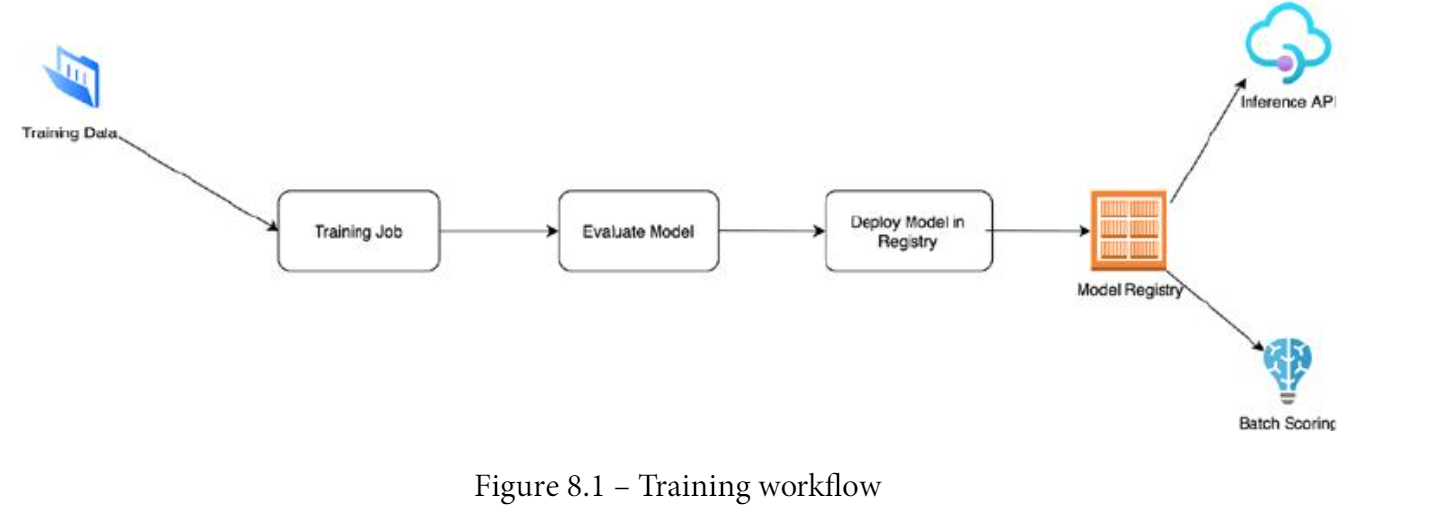

La figure 8.1 décrit à un niveau élevé le processus général, par lequel un ensemble de données de formation arrive et une tâche de formation démarre. La tâche de formation produit un modèle qui est finalement évalué et déployé dans le registre de modèles. Les systèmes en amont sont désormais en mesure de déployer des interfaces de programmation d'applications (API) d'inférence ou des tâches par lots avec le modèle nouvellement déployé.

## Création de votre projet de formation avec MLflow

Vous recevez un ficahier des charges d'un data scientist basé sur le modèle XGBoost étant prêt à passer d'une preuve de concept à une phase de production. Nous pouvons revoir le notebook Jupyter d'origine à partir duquel le modèle a été enregistré initialement par le data scientist, ce qui est un point de départ pour commencer à créer un pipeline d'ingénierie ML. Après le prototypage initial et la formation au notebook, ils sont prêts à passer à la production. Certaines entreprises vont directement produire les notebooks elles-mêmes et c'est certainement une possibilité, mais cela devient impossible pour les raisons suivantes :

* Il est difficile de version notebooks.
* Il est difficile de tester le code unitairement.
* Ce n'est pas fiable pour les tests de longue durée


Avec ces trois phases distinctes, nous assurons la reproductibilité du processus de génération de données de formation et la visibilité et la séparation claire des différentes étapes du processus. Nous commencerons par organiser notre projet MLflow en étapes et créer des espaces réservés pour chacun des composants du pipeline, comme suit :

1. Démarrez un nouveau dossier sur votre ordinateur local et nommez cette formation pystock. Ajoutez le chier MLProject, comme suit :



    name: pystock_training

    conda_env: conda.yaml

    entry_points:

      main:
        data_file: path
        command: "python main.py"

      train_model:
        command: "python train_model.py"

      evaluate_model:
        command: "python evaluate_model.py "

      register_model:
        command: "python register_model.py"


2. Ajoutez le fichier conda.yaml suivant :


    name: pystock-data-features
    channels:
      - defaults
    dependencies:
      - python=3.8
      - numpy
      - scipy
      - pandas
      - cloudpickle
      - pip:
        - git+git://github.com/mlflow/mlflow
        - sklearn
        - pandas_datareader
        - great-expectations==0.13.15
        - pandas-profiling
        - xgboost


3. Vous pouvez maintenant ajouter un exemple de fichier main.py au dossier pour vous assurer que la structure de base du projet fonctionne, comme suit :

In [ ]:
import mlflow
import click
import os

def _run(entrypoint, parameters={}, source_version=None, use_cache=True):
    #existing_run = _already_ran(entrypoint, parameters, source_version)
    #if use_cache and existing_run:
    #    print("Found existing run for entrypoint=%s and parameters=%s" % (entrypoint, parameters))
     #   return existing_run
    print("Launching new run for entrypoint=%s and parameters=%s" % (entrypoint, parameters))
    submitted_run = mlflow.run(".", entrypoint, parameters=parameters)
    return mlflow.tracking.MlflowClient().get_run(submitted_run.run_id)


@click.command()
def workflow():
    with mlflow.start_run(run_name ="pystock-training") as active_run:
        mlflow.set_tag("mlflow.runName", "pystock-training")
        train_run = _run("train_model")
        evaluate_run = _run("evaluate_model")        


        model_uri = os.path.join(train_run.info.artifact_uri,"model")
        mlflow.register_model(
           model_uri,
            "training-model-psystock")
              
        print(model_uri)
        #_run("register_model")
        
        
if __name__=="__main__":
    workflow()

4. Testez la structure de base en exécutant la commande suivante :


    mlflow run.

  Cette commande va construire votre projet en fonction de l'environnement créé par votre fichier conda.yaml et exécuter le projet de base que vous venez de créer. Il devrait y avoir une erreur, car nous devons ajouter les fichiers manquants.


À ce stade, nous avons les blocs de base du projet MLflow du pipeline de données que nous allons construire dans ce chapitre. Vous allez ensuite remplir le fichier Python pour entraîner les données

## Mettre en œuvre le travail d'apprentissage

Nous utiliserons les données d'apprentissage produites dans le chapitre précédent. L'hypothèse ici est qu'un travail indépendant remplit le pipeline de données dans un dossier spécifique. Dans le référentiel GitHub du livre, vous pouvez consulter les données dans https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter08/psystock-training/data/training/data.csv .

1. Nous allons maintenant créer un fichier train_model.py qui sera chargé de charger les données d'entraînement sur t et de produire un modèle. Des prédictions de test seront produites et conservées dans l'environnement afin que d'autres étapes du flux de travail puissent utiliser les données pour évaluer le modèle.

In [ ]:
import pandas as pd
import mlflow
import xgboost as xgb
import mlflow.xgboost
from sklearn.model_selection import train_test_split

2. Ensuite, vous devez ajouter une fonction pour exécuter la division des données en s'appuyant sur train_test_split de sklearn. Notre répartition choisie est de 33/67% pour les données de test et d'entraînement respectivement. Nous spécifions le paramètre random_state afin de rendre le processus reproductible, comme suit :

In [ ]:
def train_test_split_pandas(pandas_df,t_size=0.33,r_tate=42):
    X=pandas_df.iloc[:,:-1]
    Y=pandas_df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=t_size, random_state=r_tate)

    return X_train, X_test, y_train, 

3. Cette fonction renvoie l'ensemble de données d'apprentissage et de test et les cibles pour chaque ensemble de données. Nous nous appuyons sur le format de données xgboost matrix xgb.Dmatrix pour charger ecacement les données d'entraînement et de test et alimenter la méthode xgboost.train. Le code est illustré dans l'extrait suivant :

In [ ]:
if __name__ == "__main__":

    THRESHOLD = 0.5

    mlflow.xgboost.autolog()
    with mlflow.start_run(run_name="train_model") as run:
        mlflow.set_tag("mlflow.runName", "train_model")

        pandas_df=pd.read_csv("data/training/data.csv", header=None)

        X_train, X_test, y_train, y_test = train_test_split_pandas(pandas_df)

        train_data = xgb.DMatrix(X_train, label=y_train)
        test_data =  xgb.DMatrix(X_test)

        model = xgb.train(dtrain=train_data,params={})
        
        y_probas=model.predict(test_data) 
        y_preds = [1 if  y_proba > THRESHOLD else 0. for y_proba in y_probas]

        test_prediction_results = pd.DataFrame(data={'y_pred':y_preds,'y_test':y_test})

        result = test_prediction_results
        
        result.to_csv("data/predictions/test_predictions.csv")

4. Nous utilisons également ce moment pour produire des prédictions de test en utilisant la méthode model.predict. Une transformation de données est exécutée pour discrétiser la probabilité que le stock monte ou descend et la transforme en 0 (ne monte pas) ou 1 (monte)

5. Dans une dernière étape, nous allons persister les prédictions du test sur la variable de résultat. Nous supprimons l'index afin que le DataFrame pandas enregistré n'inclue pas l'index lors de l'exécution de la commande result.to_csv

6. Vous pouvez consulter votre interface utilisateur (UI) MLflow en exécutant la commande suivante pour voir les métriques enregistrées :


    mlflow ui


Vous devriez pouvoir consulter votre interface utilisateur MLflow, disponible dans la capture d'écran suivante, où vous pouvez voir le modèle persistant et les différentes informations sur le modèle du modèle qui vient d'être formé

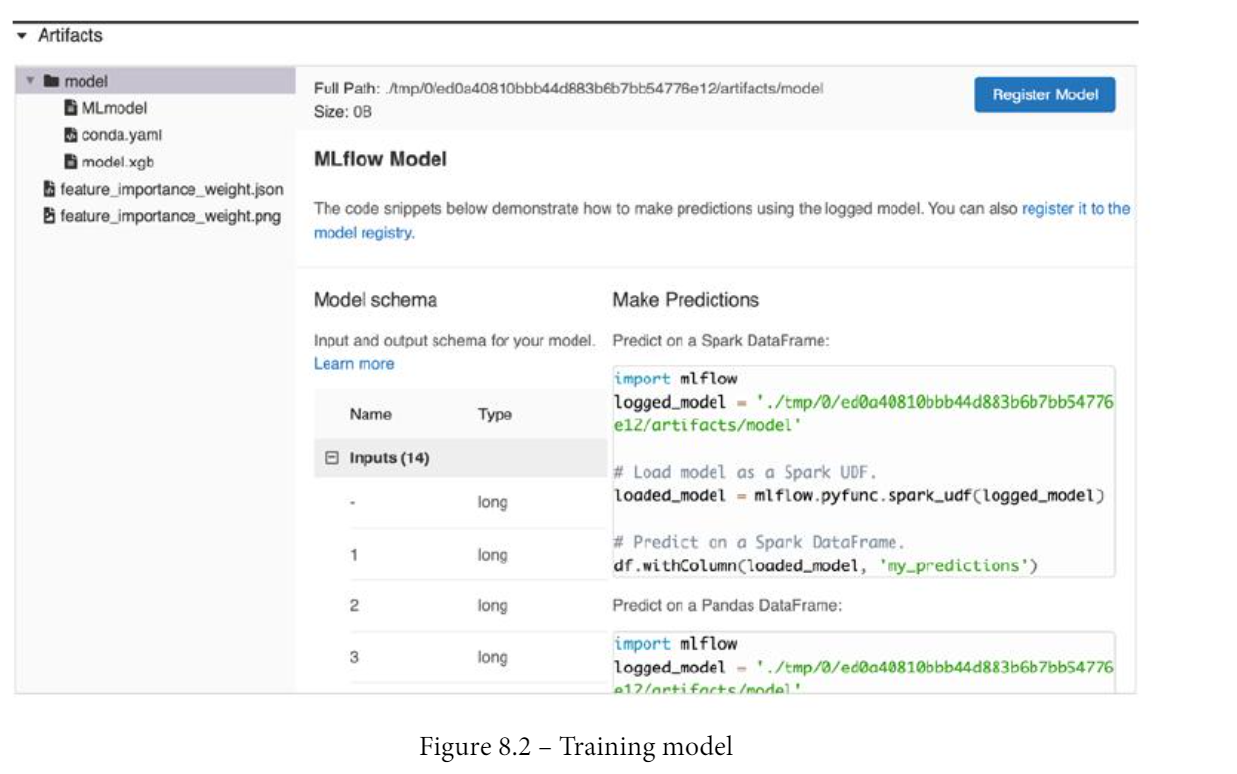


À ce stade, notre modèle est enregistré et persisté sur les artefacts de notre installation MLflow. Nous allons ensuite ajouter une nouvelle étape à notre workflow pour produire les métriques du modèle qui vient d'être produit

## Évaluer le modèle

Nous allons maintenant passer à la collecte des métriques d'évaluation de notre modèle, à ajouter aux métadonnées du modèle

Nous allons travailler sur le fichier evaluation_model.py. Vous pouvez suivre en travaillant dans un fichier vide ou en allant sur https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter08/psystock-training/evaluate_model.py. Procédez comme suit:

1. Importez les packages appropriés (pandas et mlflow) pour lire et exécuter les étapes, respectivement. Nous nous appuierons sur l'importation d'une sélection de métriques d'évaluation de modèles disponibles dans sklearn pour les algorithmes de classification, comme suit :

In [ ]:
import pandas as pd
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import  \
    classification_report, \
    confusion_matrix, \
    accuracy_score, \
    auc, \
    average_precision_score, \
    balanced_accuracy_score, \
    f1_score, \
    fbeta_score, \
    hamming_loss, \
    jaccard_score, \
    log_loss, \
    matthews_corrcoef, \
    precision_score, \
    recall_score, \
    zero_one_loss

À ce stade, nous avons importé toutes les fonctions dont nous avons besoin pour les métriques que nous devons extraire dans la section suivante.

2. Ensuite, vous devez ajouter une fonction classification_metrics pour générer des métriques basées sur un paramètre df. L'hypothèse est que le DataFrame a deux colonnes : y_pred, qui est la cible prédite par le modèle d'apprentissage, et y_test, qui est la cible présente sur le fichier de données d'apprentissage. Voici le code dont vous aurez besoin :

In [ ]:
def classification_metrics(df:None):
    metrics={}
    metrics["accuracy_score"]=accuracy_score(df["y_pred"], df["y_test"]  )
    metrics["average_precision_score"]=average_precision_score( df["y_pred"], df["y_test"]  )
    metrics["f1_score"]=f1_score( df["y_pred"], df["y_test"]  )
    metrics["jaccard_score"]=jaccard_score( df["y_pred"], df["y_test"]  )
    metrics["log_loss"]=log_loss( df["y_pred"], df["y_test"]  )
    metrics["matthews_corrcoef"]=matthews_corrcoef( df["y_pred"], df["y_test"]  )
    metrics["precision_score"]=precision_score( df["y_pred"], df["y_test"]  )
    metrics["recall_score"]=recall_score( df["y_pred"], df["y_test"]  )
    metrics["zero_one_loss"]=zero_one_loss( df["y_pred"], df["y_test"]  )
    return 

La fonction précédente produit un dictionnaire de métriques basé sur les valeurs prédites et les prédictions de test.

3. Après avoir créé cette fonction qui génère les métriques, nous devons utiliser start_run, par lequel nous lisons essentiellement le fichier de test de prédiction et exécutons les métriques. Nous publions toutes les métriques dans MLflow en utilisant la méthode mlflow.log_metrics pour enregistrer un dictionnaire de plusieurs métriques en même temps. Le code est illustré dans l'extrait suivant :

In [ ]:
if __name__ == "__main__":

    with mlflow.start_run(run_name="evaluate_model") as run:
        mlflow.set_tag("mlflow.runName", "evaluate_model")
        df=pd.read_csv("data/predictions/test_predictions.csv")
        metrics = classification_metrics(df)
        mlflow.log_metrics(metrics)

4. Nous pouvons examiner à nouveau l'interface utilisateur de MLflow, où nous pouvons voir les différentes métriques simplement persister. Vous pouvez voir le résultat ici :

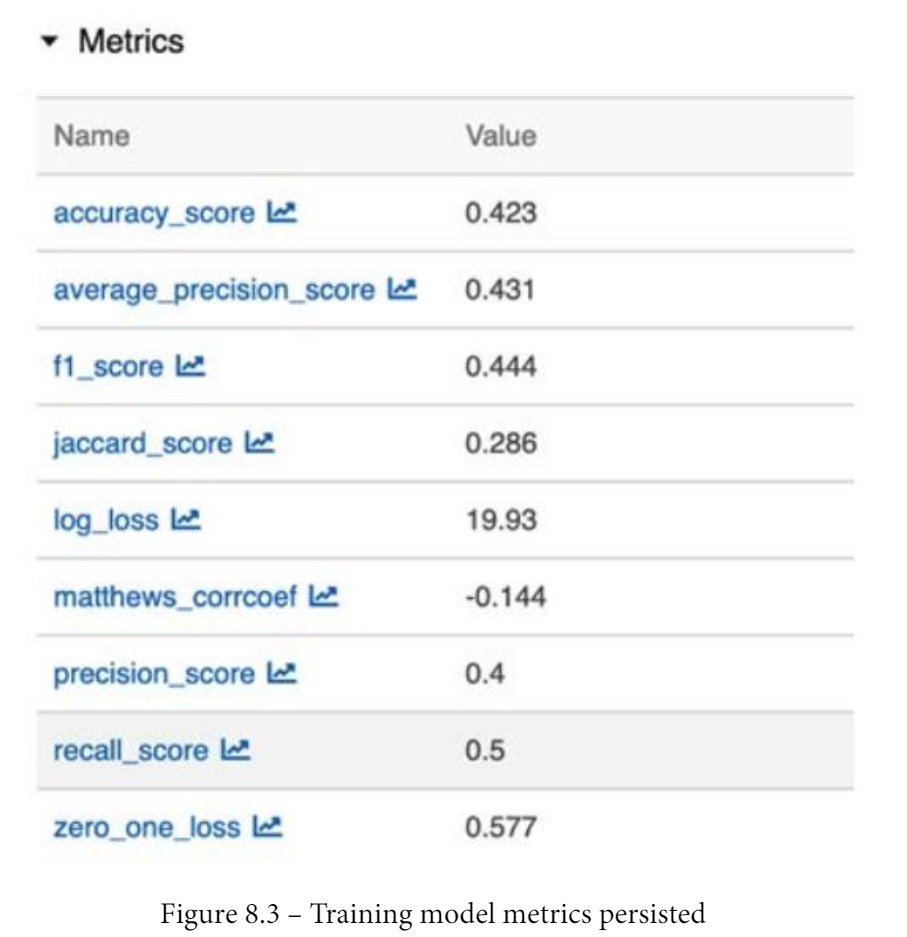

À ce stade, nous avons une évaluation de modèle pour notre travail de formation, fournissant des métriques et des informations aux implémenteurs/déployeurs de modèles. Nous allons maintenant passer à la dernière étape du processus de formation, qui consiste à enregistrer le modèle dans le registre de modèles MLflow afin qu'il puisse être déployé en production.

## Déploiement du modèle dans le registre des modèles 

Ensuite, vous devez ajouter la fonction register_model.py pour enregistrer le modèle dans le registre des modèles

Cela est aussi simple que d'exécuter la méthode mlflow.register_model avec l'identificateur de ressource uniforme (URI) du modèle et le nom du modèle. Fondamentalement, un modèle sera créé s'il n'existe pas déjà. S'il est déjà dans le registre, une nouvelle version sera ajoutée, permettant aux outils de déploiement d'examiner les modèles et de tracer les tâches et les métriques de formation. Il permet également de prendre une décision quant à la promotion ou non du modèle en production. Le code dont vous aurez besoin est illustré dans l'extrait suivant :

In [ ]:
import mlflow

if __name__ == "__main__":
    
    with mlflow.start_run(run_name="register_model") as run:

        mlflow.set_tag("mlflow.runName", "register_model")

        result = mlflow.register_model(
           "runs:/ae1a3226f71d4c029a2504feca232a35/artifacts/model",
            "training-model-psystock")

Dans la capture d'écran suivante, le modèle enregistré est présenté, et nous pouvons changer d'état et passer à la mise en scène ou à la production, en fonction de notre flux de travail :

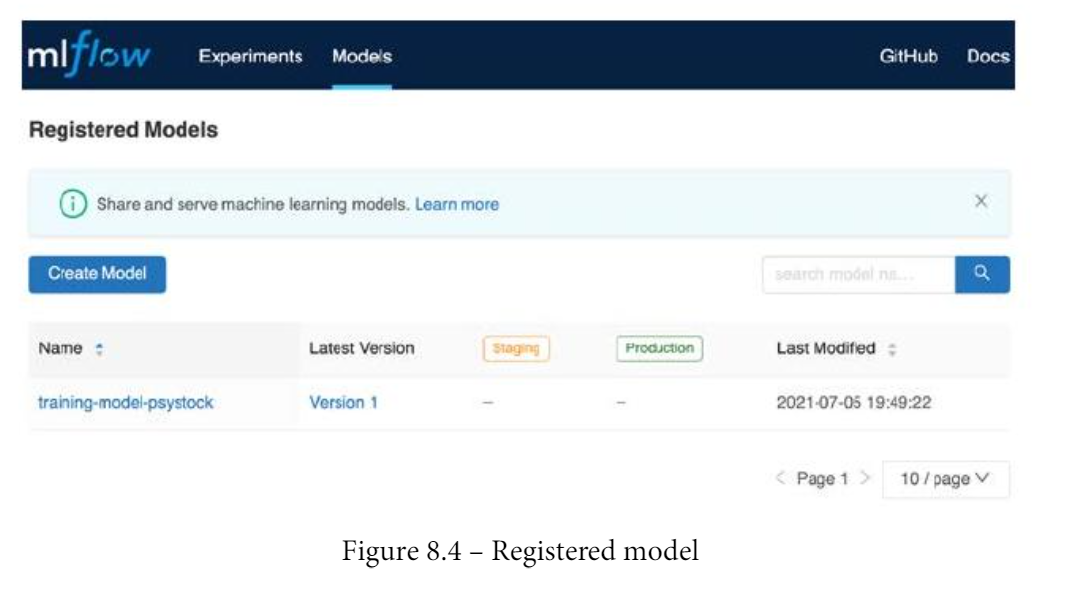

Après avoir enregistré notre modèle, nous allons maintenant passer à la préparation d'une image Docker de notre travail de formation qui peut être utilisée dans un environnement de cloud public ou dans un cluster Kubernetes

## Création d'une image Docker pour votre tâche de formation 

Une image Docker est, dans de nombreux contextes, le livrable le plus critique d'un développeur de modèle à une équipe d'infrastructure de systèmes plus spécialisée en production pour une tâche de formation. Le projet est contenu dans le dossier suivant du référentiel : https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/tree/master/Chapter08/psystock-training-docker. Dans les étapes suivantes, nous allons produire une image Docker prête à déployer du code produit : 

1. Vous devez configurer un fichier Docker dans le dossier racine du projet, comme indiqué dans l'extrait de code suivant :


    FROM continuumio/miniconda3:4.9.2

    RUN apt-get update && apt-get install build-essential -y

    RUN pip install \
        mlflow==1.18.0 \
        pymysql==1.0.2 \
        boto3

    COPY ./training_project /src

    WORKDIR /src

    ENTRYPOINT ["mlflow", "run", "."]


2. Nous allons commencer par créer et entraîner l'image en exécutant la commande suivante :



    docker build -t psystock_docker_training_image .


3. Vous pouvez exécuter votre image en spécifiant l'URL (Uniform Resource Locator) de votre serveur de suivi. Si vous utilisez une adresse locale pour votre serveur de suivi MLflow pour tester l'image nouvellement créée, vous pouvez utiliser la valeur $TRACKING_SERVER_URI pour atteindre http://host.docker.internal:5000, comme illustré dans l'extrait de code suivant :




    docker run -e MLflow_TRACKING_SERVER=$TRACKING_SERVER_URI psystock_docker_training_image


À ce stade, nous avons terminé toutes les étapes de notre processus de formation complet. Dans le chapitre suivant, nous procéderons au déploiement des différents composants de la plate-forme dans des environnements de production, en tirant parti de tous les projets MLflow créés jusqu'à présent.